In [2]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
tool = TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [22]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        # Compile graph when all requirent setups is completed. It's for tailored to runnable by langchain.f
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      
                print("\n ....bad tool name....")
                result = "bad tool name, retry" 
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [23]:
system_prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [24]:
model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=system_prompt)

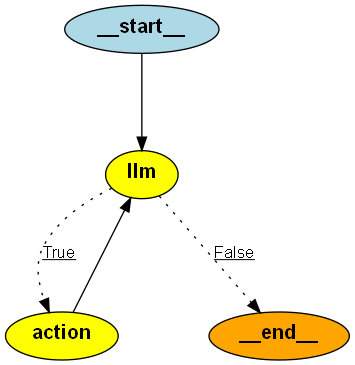

In [25]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [26]:
messages = [HumanMessage(content="What is the weather in Ankara?")]
result = abot.graph.invoke({"messages": messages})
result

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Ankara'}, 'id': 'call_HZBB0arcK9BOEpaxcKTdbtoA', 'type': 'tool_call'}
Back to the model!


{'messages': [HumanMessage(content='What is the weather in Ankara?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HZBB0arcK9BOEpaxcKTdbtoA', 'function': {'arguments': '{"query":"weather in Ankara"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ac25de2-0f4d-414b-8633-b665fff833d6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Ankara'}, 'id': 'call_HZBB0arcK9BOEpaxcKTdbtoA', 'type': 'tool_call'}], usage_metadata={'input_to

In [27]:
result['messages'][-1].content

'The current weather in Ankara is 8.3°C (46.9°F) with light rain. The humidity is at 87%, and the wind is blowing at 3.6 km/h from the WSW direction.'

In [28]:
query = "Who won the Champions Leage in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=system_prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Champions League winner 2024'}, 'id': 'call_ZBuMwExvA9L5SOBQdHakME5P', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Real Madrid headquarters location'}, 'id': 'call_HizLhgeSKerpELP9oZ8UjVzp', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of state where Real Madrid is headquartered'}, 'id': 'call_dFATD2O55ZHhYVyXRR6iFuFq', 'type': 'tool_call'}
Back to the model!


In [29]:
result['messages'][-1].content

'1. The winner of the 2024 Champions League is Real Madrid.\n\n2. Real Madrid is headquartered in Madrid, Spain.\n\n3. The GDP of the Madrid region, where Real Madrid is headquartered, was approximately 261,713 million euros in 2022.'

In [30]:
query = '''I have a three question. 
1. What is Agentic ai?
2. What is the difference between agentic and ai agents?
3. Can you tell me that are there agentic ai products in military systems currently?
Please answer each question.'''
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=system_prompt)
result = abot.graph.invoke({"messages": messages})
print(result['messages'][-1].content)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Agentic AI definition'}, 'id': 'call_yDomrLZyeaPcjQcuLNS7RSqx', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'difference between agentic and AI agents'}, 'id': 'call_0kcSwrSrB41TBZfBkwWLWSjh', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'agentic AI in military systems'}, 'id': 'call_CI653fGAfuptTLsVvEMzj9pB', 'type': 'tool_call'}
Back to the model!
1. **What is Agentic AI?**  
   Agentic AI refers to artificial intelligence systems that are capable of autonomous action and decision-making. These systems operate autonomously by making decisions and taking actions based on their understanding of their environment and predefined objectives. While guided by goals initially defined by humans, Agentic AI can act alone and adapt dynamically to changes in its environment, allowing it to handle new or ambiguous information without human guidance